In [1]:
import os

from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

import scipy
import torch
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# attention_type = "causal"
attention_type = "bidirectional"

In [3]:
token = ""

In [4]:
# model_name_or_path = "princeton-nlp/Sheared-LLaMA-1.3B"
# model_name_or_path = "meta-llama/Llama-2-7b-hf"
model_name_or_path = "meta-llama/Llama-2-7b-chat-hf"
# model_name_or_path = "mistralai/Mistral-7B-v0.1"


In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, token=token)
lm = AutoModelForCausalLM.from_pretrained(model_name_or_path, token=token)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
lm

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [7]:
text = 'Montreal is the second most populous city in Canada, the tenth most populous city in North America, and the most populous city in the province of Quebec. Founded in 1642 as Ville-Marie, or "City of Mary",[15] it is named after Mount Royal,[16] the triple-peaked hill around which the early city of Ville-Marie was built.[17] The city is centred on the Island of Montreal, which obtained its name from the same origin as the city,[18][19] and a few much smaller peripheral islands, the largest of which is Île Bizard. The city is 196 km (122 mi) east of the national capital, Ottawa, and 258 km (160 mi) southwest of the provincial capital, Quebec City.'

ids = tokenizer.encode(text)
tokens = tokenizer.convert_ids_to_tokens(ids)

input_ids = torch.tensor(ids).reshape(1, -1)
print(input_ids.shape)
print(input_ids)
print(tokens)

torch.Size([1, 183])
tensor([[    1, 26693,   338,   278,  1473,  1556, 14938,   681,  4272,   297,
          7400, 29892,   278,   260,  9097,  1556, 14938,   681,  4272,   297,
          4644,  6813, 29892,   322,   278,  1556, 14938,   681,  4272,   297,
           278, 12291,   310, 27605, 29889,   383,  7261,   297, 29871, 29896,
         29953, 29946, 29906,   408, 28153, 29899, 23572, 29892,   470,   376,
         16885,   310,  6182,   613, 29961, 29896, 29945, 29962,   372,   338,
          4257,  1156,  8040,  7021, 17094, 29896, 29953, 29962,   278, 21954,
         29899,   412, 12535, 17306,  2820,   607,   278,  4688,  4272,   310,
         28153, 29899, 23572,   471,  4240,  7226, 29896, 29955, 29962,   450,
          4272,   338,  1644,  1127,   373,   278,  7935,   310, 26693, 29892,
           607,  7625,   967,  1024,   515,   278,  1021,  3978,   408,   278,
          4272, 17094, 29896, 29947,  3816, 29896, 29929, 29962,   322,   263,
          2846,  1568,  7968, 2

In [12]:
# enable bidirectional attention
attention_mask = None
if attention_type == "bidirectional":
    # construct attention mask (batch_size, 1, seq_len, seq_len)
    attention_mask = torch.ones(size=(1, 1, len(ids), len(ids)))

    if model_name_or_path in ["princeton-nlp/Sheared-LLaMA-1.3B", "meta-llama/Llama-2-7b-hf", "meta-llama/Llama-2-7b-chat-hf"]:
        lm.model._update_causal_mask = lambda attention_mask, _: attention_mask

In [13]:
labels = input_ids
output = lm.forward(input_ids=input_ids, labels=labels, attention_mask=attention_mask, output_attentions=True, output_hidden_states=True)

In [14]:
# look at attention matrices
A = output.attentions[-1].squeeze()[-1].detach().numpy()
print(np.triu(A, k=1)) # the future

[[0.0000000e+00 3.1497484e-04 8.8648626e-04 ... 1.1623246e-02
  6.2377197e-03 2.0332222e-03]
 [0.0000000e+00 0.0000000e+00 8.0145628e-06 ... 6.3877255e-06
  1.8378779e-06 3.4377526e-06]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4492665e-06
  1.5908191e-06 1.9291733e-06]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.3244742e-01 8.9460954e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 6.3741207e-02]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [15]:
output.loss

tensor(4.4359, grad_fn=<NllLossBackward0>)

In [16]:
logits = output.logits.squeeze()
print(logits.shape)

torch.Size([183, 32000])


In [17]:
preds = torch.argmax(logits, dim=1)
print(preds.shape)

torch.Size([183])


In [18]:
preds_tokens = tokenizer.convert_ids_to_tokens(preds)

In [19]:
tokens

['<s>',
 '▁Montreal',
 '▁is',
 '▁the',
 '▁second',
 '▁most',
 '▁popul',
 'ous',
 '▁city',
 '▁in',
 '▁Canada',
 ',',
 '▁the',
 '▁t',
 'enth',
 '▁most',
 '▁popul',
 'ous',
 '▁city',
 '▁in',
 '▁North',
 '▁America',
 ',',
 '▁and',
 '▁the',
 '▁most',
 '▁popul',
 'ous',
 '▁city',
 '▁in',
 '▁the',
 '▁province',
 '▁of',
 '▁Quebec',
 '.',
 '▁F',
 'ounded',
 '▁in',
 '▁',
 '1',
 '6',
 '4',
 '2',
 '▁as',
 '▁Ville',
 '-',
 'Marie',
 ',',
 '▁or',
 '▁"',
 'City',
 '▁of',
 '▁Mary',
 '",',
 '[',
 '1',
 '5',
 ']',
 '▁it',
 '▁is',
 '▁named',
 '▁after',
 '▁Mount',
 '▁Royal',
 ',[',
 '1',
 '6',
 ']',
 '▁the',
 '▁triple',
 '-',
 'pe',
 'aked',
 '▁hill',
 '▁around',
 '▁which',
 '▁the',
 '▁early',
 '▁city',
 '▁of',
 '▁Ville',
 '-',
 'Marie',
 '▁was',
 '▁built',
 '.[',
 '1',
 '7',
 ']',
 '▁The',
 '▁city',
 '▁is',
 '▁cent',
 'red',
 '▁on',
 '▁the',
 '▁Island',
 '▁of',
 '▁Montreal',
 ',',
 '▁which',
 '▁obtained',
 '▁its',
 '▁name',
 '▁from',
 '▁the',
 '▁same',
 '▁origin',
 '▁as',
 '▁the',
 '▁city',
 ',[',
 '1',


In [20]:
preds_tokens

['Љ',
 ',',
 '▁located',
 '▁island',
 '▁language',
 '▁of',
 'ous',
 '▁city',
 ',',
 '▁Quebec',
 '.',
 '▁Quebec',
 '▁island',
 '[',
 'us',
 '▁of',
 'ous',
 '▁Quebec',
 '.',
 '▁Canada',
 'west',
 '.',
 '▁Quebec',
 '▁Quebec',
 '▁name',
 '▁popul',
 'ous',
 '.',
 ',',
 '▁Quebec',
 '▁name',
 '.',
 '▁Quebec',
 ',',
 '<0x0A>',
 'ounded',
 '.',
 '▁Quebec',
 '6',
 '▁Quebec',
 '▁Quebec',
 ']',
 ']',
 '▁Quebec',
 '-',
 'pop',
 '-',
 '▁Quebec',
 '▁"',
 'The',
 '▁of',
 '▁Quebec',
 ',',
 '▁Quebec',
 '1',
 '▁Quebec',
 '▁Quebec',
 '▁Quebec',
 '▁Quebec',
 '▁located',
 '▁Montreal',
 '▁Quebec',
 '[',
 'V',
 '7',
 '▁Quebec',
 '▁Quebec',
 '▁',
 '▁name',
 '-',
 'pop',
 'u',
 '▁the',
 '▁',
 '▁the',
 '▁is',
 '▁name',
 '▁in',
 '▁located',
 '▁Quebec',
 '-',
 '▁Quebec',
 ',',
 '▁named',
 '-',
 '1',
 '▁Quebec',
 '▁Quebec',
 '▁',
 '▁name',
 ',',
 '▁Quebec',
 'red',
 '▁city',
 '▁Montreal',
 '▁name',
 '▁of',
 '▁Quebec',
 '▁is',
 '▁Quebec',
 '▁is',
 '▁from',
 '▁name',
 '▁of',
 '▁Montreal',
 '▁name',
 '▁Quebec',
 'ated

In [21]:
len(output.hidden_states)

33

In [22]:
output.hidden_states[-1].shape

torch.Size([1, 183, 4096])

In [23]:
output.hidden_states[-1].squeeze()[10].shape

torch.Size([4096])

In [24]:
# save hidden states to disk
data_path = f"/Users/mariusmosbach/Development/mila/transformers/notebooks/hidden_states_data/{model_name_or_path.split('/')[-1]}/{attention_type}"
for layer in range(len(output.hidden_states)):
    A = output.hidden_states[layer].detach().numpy()
    file_name = f"H_layer{layer}.npy"
    with open(os.path.join(data_path, file_name), 'wb') as f:
        np.save(f, A)

---

## Compare hidden states

In [25]:
# model_name_or_path = "princeton-nlp/Sheared-LLaMA-1.3B"
# model_name_or_path = "meta-llama/Llama-2-7b-hf"
model_name_or_path = "meta-llama/Llama-2-7b-chat-hf"
# model_name_or_path = "mistralai/Mistral-7B-v0.1"

In [26]:
data_path = f"/Users/mariusmosbach/Development/mila/transformers/notebooks/hidden_states_data/{model_name_or_path.split('/')[-1]}"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


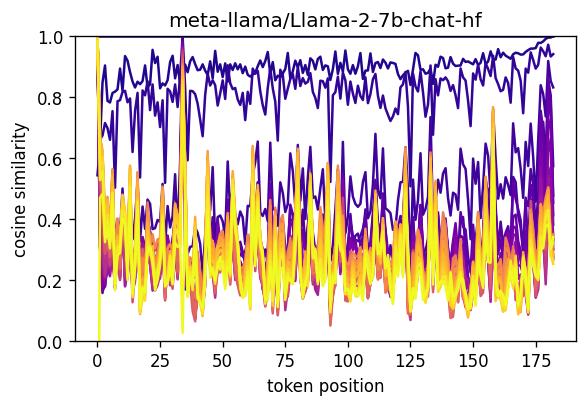

In [27]:
num_layers = 32

colors = plt.cm.plasma(np.linspace(0, 1, num_layers))

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(5, 3.5), dpi=120)

for idx, layer in enumerate(range(num_layers)):
    H_c = np.load(os.path.join(data_path, "causal", f"H_layer{layer}.npy")).squeeze()
    H_b = np.load(os.path.join(data_path, "bidirectional", f"H_layer{layer}.npy")).squeeze()
    # l2 = np.linalg.norm(H_c - H_b, axis=1)
    
    cosine_sim = [1 - scipy.spatial.distance.cosine(H_c[pos], H_b[pos]) for pos in range(len(H_c))]
    
    axes.plot(cosine_sim, label=f"layer={layer}", c=colors[idx])

# format plot
axes.set_xlabel("token position")
axes.set_ylabel("cosine similarity")
axes.set_ylim(0, 1)
# axes.set_yscale("log")
# axes.legend(loc="best", fontsize=10)

axes.set_title(model_name_or_path)

fig.tight_layout()
plt.show()
plt.close();